In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
data = pd.read_csv('/content/final_dataset.csv')

# Fill missing values in the 'final_news' column with empty strings
data['final_news'] = data['final_news'].fillna('')

# Remove rows where the label is NaN
data = data.dropna(subset=['label'])

# Clean the text by removing unwanted characters and lowercasing
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I)  # Remove non-alphabet characters
    text = text.lower().strip()  # Lowercase and remove leading/trailing whitespace
    return text

# Apply the cleaning function to the news column
data['cleaned_news'] = data['final_news'].apply(clean_text)

# Initialize the tokenizer and fit on the cleaned text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_news'])

# Convert the text to sequences (tokenized form)
sequences = tokenizer.texts_to_sequences(data['cleaned_news'])

# Set a maximum sequence length
max_length = 100  # Adjust this based on your dataset
X = pad_sequences(sequences, maxlen=max_length)

# Convert labels to integers
y = data['label'].astype(int).values

# Check for NaN values in the input data or labels
print(f"Any NaN in features: {np.isnan(X).any()}")
print(f"Any NaN in labels: {np.isnan(y).any()}")

# Ensure the labels are binary (0 or 1)
print(np.unique(y))  # Should print array([0, 1])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for class imbalance
print(np.bincount(y_train))  # Shows the distribution of classes

# Compute class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Load pre-trained GloVe embeddings
embedding_dim = 100  # Choose based on the pre-trained embeddings
vocab_size = len(tokenizer.word_index) + 1  # Size of the vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
glove_file = '/content/glove.6B.100d.txt'  # Change this to the path of your GloVe file

# Load the GloVe vectors
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word in tokenizer.word_index:
            index = tokenizer.word_index[word]
            embedding_matrix[index] = np.asarray(values[1:], dtype='float32')

# Define a more complex LSTM model with Bidirectional LSTM and trainable embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_length,
                    weights=[embedding_matrix],
                    trainable=True))  # Set embeddings to be trainable

# Add Bidirectional LSTM for better accuracy
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.5))  # Add dropout for regularization

# Add another LSTM layer for more complexity
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.5))

# Dense layer and output
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
optimizer = RMSprop(learning_rate=0.0001)  # Lower learning rate for better accuracy
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_test, y_test),
                    class_weight=dict(enumerate(class_weights)),
                    callbacks=[early_stopping])

# Evaluate the model on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Any NaN in features: False
Any NaN in labels: False
[0 1]
[10169 10631]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 369s 559ms/step - accuracy: 0.6092 - loss: 0.6534 - val_accuracy: 0.7819 - val_loss: 0.4779
Epoch 2/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 376s 579ms/step - accuracy: 0.7773 - loss: 0.4930 - val_accuracy: 0.8077 - val_loss: 0.4319
Epoch 3/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 366s 554ms/step - accuracy: 0.8025 - loss: 0.4496 - val_accuracy: 0.8162 - val_loss: 0.4274
Epoch 4/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 371s 572ms/step - accuracy: 0.8203 - loss: 0.4210 - val_accuracy: 0.8346 - val_loss: 0.3932
Epoch 5/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 368s 549ms/step - accuracy: 0.8311 - loss: 0.4040 - val_accuracy: 0.8215 - val_loss: 0.4040
Epoch 6/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 384s 554ms/step - accuracy: 0.8416 - loss: 0.3935 - val_accuracy: 0.8392 - val_loss: 0.3895
Epoch 7/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 377s 546ms/step - accuracy: 0.8530 - loss: 0.3668 - val_accuracy: 0.8375 - val_loss: 0.3890
Epoch 8/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 352s 542ms/step - accuracy: 0.8536 -

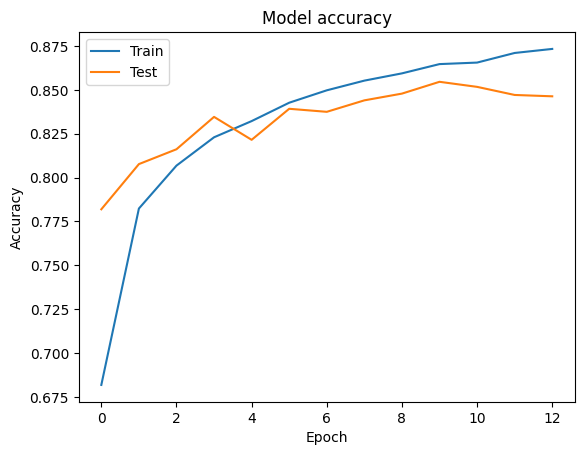

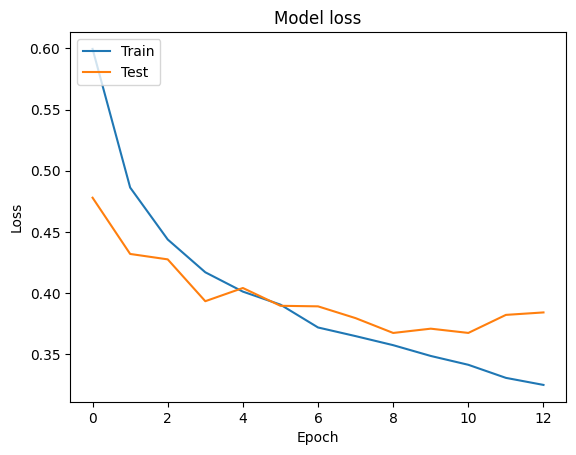

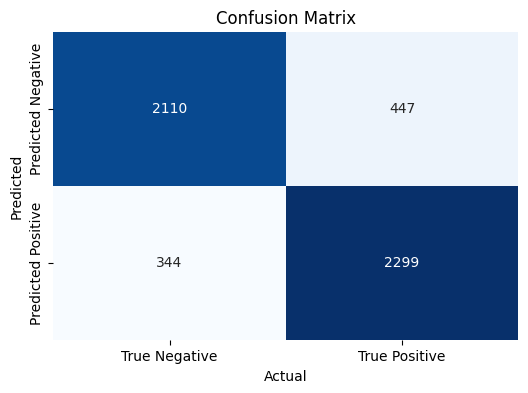

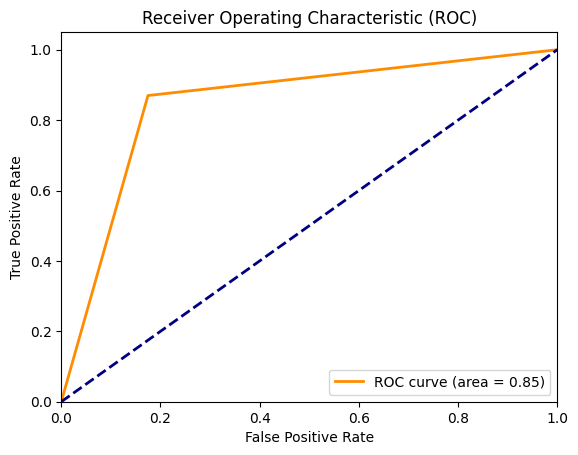

In [4]:
# prompt: give the code for all the possible graphs

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['True Negative', 'True Positive'],
            yticklabels=['Predicted Negative', 'Predicted Positive'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC curve and AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [5]:
# prompt: code for classification report

from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the report
print(report)


              precision    recall  f1-score   support

           0       0.86      0.83      0.84      2557
           1       0.84      0.87      0.85      2643

    accuracy                           0.85      5200
   macro avg       0.85      0.85      0.85      5200
weighted avg       0.85      0.85      0.85      5200



In [6]:
# prompt: when the user gives an input, this model should predict if the given news is real or fake

def predict_news(news_text):
  """Predicts whether the given news is real or fake.

  Args:
    news_text: The text of the news article.

  Returns:
    A string indicating whether the news is predicted to be real or fake.
  """
  cleaned_text = clean_text(news_text)
  sequence = tokenizer.texts_to_sequences([cleaned_text])
  padded_sequence = pad_sequences(sequence, maxlen=max_length)
  prediction = model.predict(padded_sequence)[0][0]

  if prediction > 0.5:
    return "Fake News"
  else:
    return "Real News"


# Get user input
user_input = input("Enter the news text: ")

# Predict and print the result
prediction_result = predict_news(user_input)
print(f"Prediction: {prediction_result}")


Enter the news text: The state government is nearing the final stages of selecting a site for Bengaluru's second international airport, with the location likely to be near Nelamangala. After thorough evaluation, the area between Nelamangala and Kunigal, along National Highway 75, has been identified as the most suitable for the new airport, according to sources.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Prediction: Fake News


In [7]:
# prompt: when the user gives an input, this model should predict if the given news is real or fake

def predict_news(news_text):
  """Predicts whether the given news is real or fake.

  Args:
    news_text: The text of the news article.

  Returns:
    A string indicating whether the news is predicted to be real or fake.
  """
  cleaned_text = clean_text(news_text)
  sequence = tokenizer.texts_to_sequences([cleaned_text])
  padded_sequence = pad_sequences(sequence, maxlen=max_length)
  prediction = model.predict(padded_sequence)[0][0]

  if prediction > 0.5:
    return "Fake News"
  else:
    return "Real News"


# Get user input
user_input = input("Enter the news text: ")

# Predict and print the result
prediction_result = predict_news(user_input)
print(f"Prediction: {prediction_result}")


Enter the news text: Fred Rogers served as a sniper during the Vietnam War and had a large number of confirmed kills. Fred Rogers wore his iconic sweaters to conceal the extensive tattoos on his arms that were acquired while serving in the military.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction: Fake News
